In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from pathlib import Path
from logging import Logger
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
from operator import itemgetter, attrgetter
import itertools

from utils.setup import easy_logger, get_device

PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
logger: Logger = easy_logger(f'{PROJECT_DIR}/log/jupyter_run.log')
device = get_device(device_name='cpu', logger=logger)

In [2]:
# jupyter
import seaborn as sns
import matplotlib.pyplot as plt
# Machine learning
import numpy as np
import pandas as pd
import h5py
import optuna
# torch
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
# torch ignite
from ignite.engine import Engine
from ignite.handlers import Checkpoint
# My items
from models.datasets.data_helper import MyDataHelper, MyDataLoaderHelper, DefaultTokens
from models.datasets.datasets_for_story import StoryTriple
# My utils
from utils.setup import load_param
from utils.torch import load_model, torch_fix_seed
# main function
from run_for_KGC import main_function


In [3]:
from const.const_values import CPU, MODEL
from models.KGModel.kg_model import HEAD, RELATION, TAIL
from utils.torch_ignite import TRAINER, EVALUATOR
from const.const_values import DATASETS, DATA_HELPER, DATA_LOADERS, TRAIN_RETURNS

In [4]:
SEED: Final[int] = 42
args_path = f'{PROJECT_DIR}/models/230114/01/param.pkl'


In [5]:
args = load_param(args_path)

# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.pre_train=False
args.init_embedding_using_bert = False
del args.optuna_file, args.device_name, args.pid, args.study_name, args.n_trials
logger.info(args)

2023-01-21 03:21:02 - INFO - 2806402167.py - 10 - Namespace(notebook=False, console_level='info', logfile='saved_models/230114/01/log.log', param_file='saved_models/230114/01/param.pkl', train_anyway=False, tensorboard_dir='saved_models/230114/01/tensorboard', checkpoint_dir='saved_models/230114/01/checkpoint/', model_path='saved_models/230114/01/model.pth', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=False, resume_checkpoint_path=None, pre_train=False, train_valid_test=True, only_train=False, use_for_challenge100=False, use_for_challenge090=False, use_for_challenge075=False, use_title=None, do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_token_s=4, model_version='03a', embedding_di

In [6]:
torch_fix_seed(seed=SEED)
return_dict = main_function(args, logger=logger)

2023-01-21 03:21:07 - INFO - run_for_KGC.py - 820 - ----- make datahelper start. -----
2023-01-21 03:21:07 - INFO - data_helper.py - 331 - ====== Show MyRawData ======
2023-01-21 03:21:07 - INFO - data_helper.py - 332 - entity num: 7844
2023-01-21 03:21:07 - INFO - data_helper.py - 333 - relation num: 63
2023-01-21 03:21:07 - INFO - data_helper.py - 334 - ====== Show MyRawData ======
2023-01-21 03:21:07 - INFO - data_helper.py - 605 - ========== Show DataHelper ==========
2023-01-21 03:21:07 - INFO - data_helper.py - 331 - ====== Show MyRawData ======
2023-01-21 03:21:07 - INFO - data_helper.py - 332 - entity num: 7844
2023-01-21 03:21:07 - INFO - data_helper.py - 333 - relation num: 63
2023-01-21 03:21:07 - INFO - data_helper.py - 334 - ====== Show MyRawData ======
2023-01-21 03:21:07 - INFO - data_helper.py - 607 - entity_special_dicts: {0: '<pad_e>', 1: '<cls_e>', 2: '<mask_e>', 3: '<sep_e>', 4: '<bos_e>'}
2023-01-21 03:21:07 - INFO - data_helper.py - 608 - relation_special_dicts: {

In [7]:
model = return_dict[MODEL]
model.eval()

dataset_train: StoryTriple = return_dict[DATASETS][0]
triple: torch.Tensor = dataset_train.triple
data_helper: MyDataHelper = return_dict[DATA_HELPER]
evaluator: Checkpoint = return_dict[TRAIN_RETURNS][EVALUATOR]

load_model(model, args.model_path, device)

entities, relations = data_helper.processed_entities, data_helper.processed_relations
d_e, d_r = {e: i for i, e in enumerate(entities)}, {r: i for i, r in enumerate(relations)}

triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=[HEAD, RELATION, TAIL])
story_entities = triple_df[HEAD].tolist()

In [8]:
triple_df

,head,relation,tail
0,<bos_e>,<bos_r>,<bos_e>
1,AbbeyGrange:001,kgc:whom,AllTitle:Watson
2,AbbeyGrange:001,kgc:infoSource,AllTitle:Watson
3,AbbeyGrange:001,kgc:when,AbbeyGrange:Winter_of_1897
4,AbbeyGrange:001,kgc:when,AbbeyGrange:1897-02-01T08
...,...,...,...
15056,AbbeyGrange:104,kgc:subject,AbbeyGrange:corpse
15057,AbbeyGrange:104,kgc:infoSource,AllTitle:Watson
15058,AbbeyGrange:104,kgc:on,AbbeyGrange:back
15059,<bos_e>,<bos_r>,<bos_e>


In [10]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        global features
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    handle = target.register_forward_hook(forward_hook)

    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    handle.remove()

    return features

In [11]:
def get_attention(input_):
    assert len(input_) == 1
    features = extract(model, model.transformer.layers[-1].self_attn, input_)[0]
    df_attention = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_attention.columns=[HEAD, RELATION, TAIL] + [f'atten_from{i}' for i in range(len(df_attention.columns)-3)]
    return df_attention

def show_attension_heatmap(df_attention):
    sns.heatmap(df_attention.iloc[:,3:])
    plt.show()

In [12]:
bos_triple = [d_e[DefaultTokens.BOS_E], d_r[DefaultTokens.BOS_R],d_e[DefaultTokens.BOS_E]]
mask_e_id = d_e[DefaultTokens.MASK_E]
Holmes_id =d_e['AllTitle:Holmes']

def make_ranking(from_story_name, to_story_name, predicate_, whom_, subject_, why_, what_, where_):
    if not (from_story_name is None and to_story_name is None):
        _start_index = story_entities.index(from_story_name)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(to_story_name)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            bos_triple, 
            [mask_e_id, d_r['kgc:infoSource'],     Holmes_id      ],
            [mask_e_id, d_r['kgc:hasPredicate'],   d_e[predicate_]],
            [mask_e_id, d_r['kgc:whom'],           d_e[whom_     ]],
            [mask_e_id, d_r['kgc:subject'],        d_e[subject_  ]],
            [mask_e_id, d_r['kgc:why'],            d_e[why_      ]],
            [mask_e_id, d_r['kgc:what'],           d_e[what_     ]],
            [mask_e_id, d_r['kgc:where'],          d_e[where_    ]],
        ]
    )
    mask_ = torch.zeros_like(question_, dtype=torch.bool) # not mask all position
    mask_[1:, 0] = True                                   # where head position without bos token
    mask_[1:, 2] = True                                   # where tail position without bos token

    last_triples = triple[_start_index: _end_index]

    questions = torch.cat([last_triples, question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros_like(last_triples), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)

    data_list = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred, dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_pred, whom_pred, subject_pred, why_pred, what_pred, where_pred = ans_
            data_list.append([entities[predicate_pred], entities[whom_pred], entities[subject_pred], entities[why_pred], entities[what_pred], entities[where_pred]])
    df_ranking = pd.DataFrame(data_list, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = get_attention(questions)
    
    return df_ranking, df_attension

In [13]:
MASK_E = DefaultTokens.MASK_E
KILL = 'word.predicate:kill'

def main_func01(_title, _victim_name, criminal, predicate, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    predicate = predicate
    victim = f'{_title}:{_victim_name}'
    criminal = f'{_title}:{criminal}'
    df_ranking, df_attension = make_ranking(
        from_, to_, predicate, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    pred_rank = df_ranking.index[df_ranking['subject']==criminal].tolist()[0]
    logger.info(f"The pred ranking about {criminal} is {pred_rank}")
    display(df_ranking.iloc[:max(20, pred_rank)])
    len_ = len(df_attension)
    for i in range(len_-10, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

def check_killer(_title, _victim_name, _killer_name, _last_index, _story_len):
    return main_func01(_title, _victim_name, _killer_name, KILL, _last_index, _story_len)

In [14]:
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

### まだらの紐
Who killed Julia? (criminal & explanation)
被害者: Julia
犯人: Roylott
犯行に用いたもの: snake
犯行動機: 母の相続財産を独占したい

In [16]:
show_attension_heatmap

2023-01-21 03:22:39 - INFO - 2822292237.py - 14 - The pred ranking about SpeckledBand:Roylott is 2


,predicate,whom,subject,why,what,where
0,word.predicate:impress,SpeckledBand:culprit,SpeckledBand:culprit,DateTime:1883-04-01T23:00:00,SpeckledBand:today,SpeckledBand:the_time_of_Helen_s_mothers_death
1,word.predicate:question,SpeckledBand:today,SpeckledBand:today,DateTime:1883-04-02T04:00:00,DancingMen:Cubitt,SpeckledBand:using_rope
2,word.predicate:stabble,SpeckledBand:west_building,SpeckledBand:Roylott,SpeckledBand:1883-04-02T04,SpeckledBand:request,SpeckledBand:four_walls_of_Julia_s_bedroom
3,word.predicate:testify,DancingMen:Cubitt,SpeckledBand:craftsman,SpeckledBand:today,DateTime:1883-04-02T04:00:00,SpeckledBand:bruise
4,word.predicate:execute,AbbeyGrange:Only_one_woman,DancingMen:Cubitt,SpeckledBand:1883-04-01T23,SpeckledBand:using_rope,SpeckledBand:first_floor_of_one_building_of_ma...
5,word.predicate:beKnown,SpeckledBand:Roylott,SpeckledBand:west_building,DancingMen:Cubitt,SpeckledBand:first_floor_of_one_building_of_ma...,SpeckledBand:match_box
6,word.predicate:notReach,SpeckledBand:using_rope,SpeckledBand:using_rope,SpeckledBand:1881-12-02T00,SpeckledBand:1883-04-02T04,SpeckledBand:eye
7,word.predicate:cannotMove,SpeckledBand:first_floor_of_one_building_of_ma...,SpeckledBand:man,SpeckledBand:1883-04-01T15,SpeckledBand:culprit,SpeckledBand:today
8,word.predicate:gangUp,SpeckledBand:craftsman,DancingMen:Abe_Slaney,SpeckledBand:first_floor_of_one_building_of_ma...,DateTime:1883-04-01T23:00:00,SpeckledBand:1883-04-01T15
9,word.predicate:confirm,SpeckledBand:man,SpeckledBand:first_floor_of_one_building_of_ma...,DateTime:1898-08-13T03:00:00,SpeckledBand:west_building,SpeckledBand:request


380

['SpeckledBand:401', 'kgc:subject', 'SpeckledBand:Roma']

,head,relation,tail,atten_from380
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.100270
278,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.077584
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.037620
255,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.029483
273,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.028936
284,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.025924
288,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.025818
300,SpeckledBand:383,kgc:what,SpeckledBand:384,0.023117
267,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.020625
298,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.020378


----------


381

['SpeckledBand:401', 'kgc:hasProperty', 'word.predicate:band']

,head,relation,tail,atten_from381
298,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.039822
312,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.023139
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.022762
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.022463
315,SpeckledBand:387,kgc:subject,SpeckledBand:Roylott,0.019085
324,SpeckledBand:389,kgc:subject,SpeckledBand:Roylott,0.017126
273,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.016269
232,SpeckledBand:369,kgc:subject,SpeckledBand:Julia,0.016134
320,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.015789
182,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.014203


----------


382

['<bos_e>', '<bos_r>', '<bos_e>']

,head,relation,tail,atten_from382
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.017626
300,SpeckledBand:383,kgc:what,SpeckledBand:384,0.015829
278,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.014167
302,SpeckledBand:383,kgc:what,SpeckledBand:386,0.013746
288,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.013417
162,SpeckledBand:355,kgc:subject,SpeckledBand:Roylott,0.012289
370,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.012182
303,SpeckledBand:383,kgc:what,SpeckledBand:387,0.011365
299,SpeckledBand:383,kgc:hasPredicate,word.predicate:train,0.010914
255,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.010710


----------


383

['<mask_e>', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from383
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.047307
278,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.040972
255,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.033847
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.028748
368,SpeckledBand:398,kgc:time,DateTime:1883-04-01T23:00:00,0.026713
288,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.022353
335,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.021548
267,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.018672
273,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.017744
371,SpeckledBand:399,kgc:hasPredicate,word.predicate:return,0.017498


----------


384

['<mask_e>', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from384
381,SpeckledBand:401,kgc:hasProperty,word.predicate:band,0.029385
325,SpeckledBand:389,kgc:hasPredicate,word.predicate:reach,0.018768
324,SpeckledBand:389,kgc:subject,SpeckledBand:Roylott,0.017812
320,SpeckledBand:388,kgc:subject,SpeckledBand:Roylott,0.014975
370,SpeckledBand:399,kgc:subject,SpeckledBand:snake,0.013043
326,SpeckledBand:389,kgc:to,SpeckledBand:VentilationHole,0.012065
237,SpeckledBand:370,kgc:hasPredicate,word.predicate:notEnter,0.011074
384,<mask_e>,kgc:hasPredicate,word.predicate:kill,0.010702
331,SpeckledBand:390,kgc:where,SpeckledBand:Roylott_s_bedroom,0.010352
380,SpeckledBand:401,kgc:subject,SpeckledBand:Roma,0.010318


----------


385

['<mask_e>', 'kgc:whom', 'SpeckledBand:Julia']

,head,relation,tail,atten_from385
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.048634
278,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.043163
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.039957
288,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.034416
255,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.033741
273,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.026576
303,SpeckledBand:383,kgc:what,SpeckledBand:387,0.025036
267,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.024451
335,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.021076
302,SpeckledBand:383,kgc:what,SpeckledBand:386,0.019622


----------


386

['<mask_e>', 'kgc:subject', '<mask_e>']

,head,relation,tail,atten_from386
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.109856
278,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.081684
288,SpeckledBand:379,kgc:time,DateTime:1873-04-01T15:00:00,0.045614
255,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.045423
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.039875
267,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.026124
273,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.025952
300,SpeckledBand:383,kgc:what,SpeckledBand:384,0.025403
335,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.023242
302,SpeckledBand:383,kgc:what,SpeckledBand:386,0.020971


----------


387

['<mask_e>', 'kgc:why', '<mask_e>']

,head,relation,tail,atten_from387
224,SpeckledBand:367,kgc:time,DateTime:1883-04-02T04:00:00,0.021662
298,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.018421
284,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.017254
271,SpeckledBand:376,kgc:infoSource,AllTitle:Holmes,0.016287
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.015013
206,SpeckledBand:364,kgc:time,DateTime:1883-04-02T04:00:00,0.014873
312,SpeckledBand:386,kgc:subject,SpeckledBand:Roylott,0.014859
163,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.014697
230,SpeckledBand:368,kgc:time,DateTime:1883-04-01T23:00:00,0.014108
212,SpeckledBand:365,kgc:time,DateTime:1883-04-02T04:00:00,0.012884


----------


388

['<mask_e>', 'kgc:what', '<mask_e>']

,head,relation,tail,atten_from388
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.062956
298,SpeckledBand:383,kgc:subject,SpeckledBand:Roylott,0.035649
284,SpeckledBand:379,kgc:subject,SpeckledBand:Roylott,0.034781
278,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.029344
247,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.023477
255,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.022600
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.019900
273,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.019497
163,SpeckledBand:355,kgc:time,DateTime:1883-04-02T04:00:00,0.017415
267,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.017285


----------


389

['<mask_e>', 'kgc:where', '<mask_e>']

,head,relation,tail,atten_from389
282,SpeckledBand:378,kgc:time,DateTime:1883-04-01T15:00:00,0.084984
278,SpeckledBand:377,kgc:time,DateTime:1883-04-01T15:00:00,0.041510
273,SpeckledBand:376,kgc:time,DateTime:1883-04-01T15:00:00,0.037017
373,SpeckledBand:399,kgc:time,DateTime:1883-04-01T23:00:00,0.024566
267,SpeckledBand:375,kgc:time,DateTime:1883-04-01T15:00:00,0.024217
255,SpeckledBand:373,kgc:time,DateTime:1883-04-01T15:00:00,0.020917
247,SpeckledBand:371,kgc:time,DateTime:1883-04-01T15:00:00,0.020575
367,SpeckledBand:398,kgc:when,SpeckledBand:1883-04-01T23,0.018744
335,SpeckledBand:391,kgc:time,DateTime:1881-04-02T00:30:00,0.017829
182,SpeckledBand:359,kgc:when,SpeckledBand:1883-04-02T04,0.014922


----------


### 悪魔の足跡１
Who killed the victims? (criminal & explanation)
被害者: Brenda
犯人: Mortimer
犯行動機: 財産

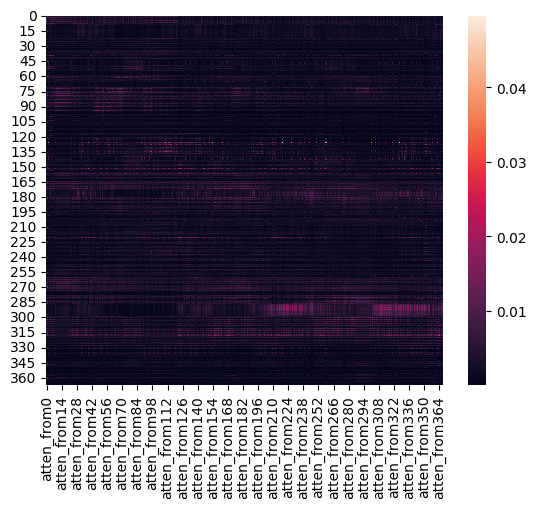

2023-01-21 03:09:55 - INFO - 2822292237.py - 14 - The pred ranking about DevilsFoot:Mortimer is 1


,predicate,whom,subject,why,what,where
0,word.predicate:exist,DevilsFoot:Sterndale,DevilsFoot:Sterndale,DevilsFoot:Sterndale,<bos_e>,DevilsFoot:Sterndale
1,word.predicate:go,DevilsFoot:Mortimer,DevilsFoot:Mortimer,DevilsFoot:Roundhay,DevilsFoot:Sterndale,<bos_e>
2,<bos_e>,DevilsFoot:Brenda,DevilsFoot:Brenda,DevilsFoot:Mortimer,DevilsFoot:Mortimer,DevilsFoot:Mortimer
3,word.predicate:meet,DevilsFoot:George,DevilsFoot:Roundhay,<bos_e>,DevilsFoot:George,DevilsFoot:George
4,word.predicate:think,<bos_e>,DevilsFoot:George,DevilsFoot:George,DevilsFoot:Brenda,DevilsFoot:Roundhay
5,word.predicate:enter,DevilsFoot:Roundhay,AllTitle:Holmes,DevilsFoot:Brenda,DevilsFoot:Roundhay,DevilsFoot:Brenda
6,word.predicate:return,AllTitle:Holmes,DevilsFoot:Owen,DevilsFoot:Owen,DevilsFoot:Owen,AllTitle:Holmes
7,word.predicate:have,DevilsFoot:Owen,<bos_e>,DevilsFoot:Porter,AllTitle:Holmes,DevilsFoot:cottage_of_Pordeux_Bay
8,word.predicate:see,DevilsFoot:Porter,DevilsFoot:Porter,DevilsFoot:telegram,DevilsFoot:Porter,DevilsFoot:Owen
9,word.predicate:kill,DevilsFoot:Doctor_Richard,DevilsFoot:Doctor_Richard,DevilsFoot:window,DevilsFoot:window,DevilsFoot:window


358

['DevilsFoot:489', 'kgc:hasPredicate', 'word.predicate:find']

,head,relation,tail,atten_from358
152,DevilsFoot:441,kgc:infoSource,DevilsFoot:Sterndale,0.024672
126,DevilsFoot:436,kgc:infoSource,DevilsFoot:Sterndale,0.020354
331,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.013020
220,DevilsFoot:457,kgc:infoSource,DevilsFoot:Sterndale,0.012281
335,DevilsFoot:482,kgc:infoSource,DevilsFoot:Sterndale,0.010973
122,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.009299
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.008737
157,DevilsFoot:442,kgc:infoSource,DevilsFoot:Sterndale,0.008555
288,DevilsFoot:473,kgc:what,DevilsFoot:475,0.007570
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.007494


----------


359

['DevilsFoot:489', 'kgc:what', 'DevilsFoot:gravel']

,head,relation,tail,atten_from359
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.013493
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.012848
288,DevilsFoot:473,kgc:what,DevilsFoot:475,0.011465
293,DevilsFoot:473,kgc:what,DevilsFoot:480,0.010335
296,DevilsFoot:473,kgc:what,DevilsFoot:484,0.010059
291,DevilsFoot:473,kgc:what,DevilsFoot:478,0.009799
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.009511
294,DevilsFoot:473,kgc:what,DevilsFoot:481,0.009355
280,DevilsFoot:472,kgc:subject,DevilsFoot:Sterndale,0.009175
286,DevilsFoot:473,kgc:subject,DevilsFoot:Sterndale,0.009121


----------


360

['<bos_e>', '<bos_r>', '<bos_e>']

,head,relation,tail,atten_from360
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.009026
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.008331
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007701
273,DevilsFoot:471,kgc:subject,DevilsFoot:Mortimer,0.007217
71,<bos_e>,<bos_r>,<bos_e>,0.006787
80,<bos_e>,<bos_r>,<bos_e>,0.006762
87,<bos_e>,<bos_r>,<bos_e>,0.006745
182,<bos_e>,<bos_r>,<bos_e>,0.006706
308,DevilsFoot:476,kgc:subject,DevilsFoot:Mortimer,0.006680
76,<bos_e>,<bos_r>,<bos_e>,0.006636


----------


361

['<mask_e>', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from361
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.013553
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.013034
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.011669
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.010840
8,DevilsFoot:412,kgc:hasPredicate,word.predicate:say,0.010628
281,DevilsFoot:472,kgc:hasPredicate,word.predicate:say,0.010471
304,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.010062
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.009839
315,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.009805
179,DevilsFoot:446,kgc:what,DevilsFoot:444,0.009375


----------


362

['<mask_e>', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from362
152,DevilsFoot:441,kgc:infoSource,DevilsFoot:Sterndale,0.030113
126,DevilsFoot:436,kgc:infoSource,DevilsFoot:Sterndale,0.027814
331,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.020243
220,DevilsFoot:457,kgc:infoSource,DevilsFoot:Sterndale,0.014856
335,DevilsFoot:482,kgc:infoSource,DevilsFoot:Sterndale,0.014836
122,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.011744
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.011638
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.010709
157,DevilsFoot:442,kgc:infoSource,DevilsFoot:Sterndale,0.009946
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.009787


----------


363

['<mask_e>', 'kgc:whom', 'DevilsFoot:Brenda']

,head,relation,tail,atten_from363
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.020483
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.019791
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.016862
315,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.013732
308,DevilsFoot:476,kgc:subject,DevilsFoot:Mortimer,0.013424
304,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.012795
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.011732
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.011604
152,DevilsFoot:441,kgc:infoSource,DevilsFoot:Sterndale,0.011558
306,DevilsFoot:475,kgc:infoSource,DevilsFoot:Sterndale,0.011499


----------


364

['<mask_e>', 'kgc:subject', '<mask_e>']

,head,relation,tail,atten_from364
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.028069
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.023580
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.020506
152,DevilsFoot:441,kgc:infoSource,DevilsFoot:Sterndale,0.015805
315,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.015557
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.013819
304,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.013480
306,DevilsFoot:475,kgc:infoSource,DevilsFoot:Sterndale,0.012717
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.012317
220,DevilsFoot:457,kgc:infoSource,DevilsFoot:Sterndale,0.011709


----------


365

['<mask_e>', 'kgc:why', '<mask_e>']

,head,relation,tail,atten_from365
181,DevilsFoot:446,kgc:infoSource,DevilsFoot:Sterndale,0.007534
172,DevilsFoot:446,kgc:subject,DevilsFoot:Sterndale,0.007220
87,<bos_e>,<bos_r>,<bos_e>,0.006813
183,DevilsFoot:447,kgc:subject,DevilsFoot:Sterndale,0.006804
273,DevilsFoot:471,kgc:subject,DevilsFoot:Mortimer,0.006793
286,DevilsFoot:473,kgc:subject,DevilsFoot:Sterndale,0.006663
284,DevilsFoot:472,kgc:infoSource,DevilsFoot:Sterndale,0.006494
271,DevilsFoot:470,kgc:infoSource,DevilsFoot:Sterndale,0.006469
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.006448
186,DevilsFoot:448,kgc:subject,DevilsFoot:Mortimer,0.006432


----------


366

['<mask_e>', 'kgc:what', '<mask_e>']

,head,relation,tail,atten_from366
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.015509
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.015444
288,DevilsFoot:473,kgc:what,DevilsFoot:475,0.012809
286,DevilsFoot:473,kgc:subject,DevilsFoot:Sterndale,0.012253
294,DevilsFoot:473,kgc:what,DevilsFoot:481,0.011768
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.011670
296,DevilsFoot:473,kgc:what,DevilsFoot:484,0.011668
291,DevilsFoot:473,kgc:what,DevilsFoot:478,0.011569
8,DevilsFoot:412,kgc:hasPredicate,word.predicate:say,0.010672
293,DevilsFoot:473,kgc:what,DevilsFoot:480,0.010596


----------


367

['<mask_e>', 'kgc:where', '<mask_e>']

,head,relation,tail,atten_from367
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.014898
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.013924
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.012411
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.010702
243,DevilsFoot:463,kgc:subject,DevilsFoot:Mortimer,0.010224
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.010073
186,DevilsFoot:448,kgc:subject,DevilsFoot:Mortimer,0.009921
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.009733
128,DevilsFoot:437,kgc:subject,DevilsFoot:Mortimer,0.009711
326,DevilsFoot:481,kgc:subject,DevilsFoot:Mortimer,0.009333


----------


In [33]:
def do_devil1_pred():
    title = 'DevilsFoot'
    victim_name = 'Brenda'
    killer_name = 'Mortimer'
    last_index = 489
    story_len = 80
    df_ranking_DevilsFoot1, df_attension_DevilsFoot1 = check_killer(title, victim_name, killer_name, last_index, story_len)
do_devil1_pred()

### 悪魔の足跡2
Who killed the victims? (criminal & explanation)
被害者: Mortimer
犯人: 
犯行動機: 恋人の敵

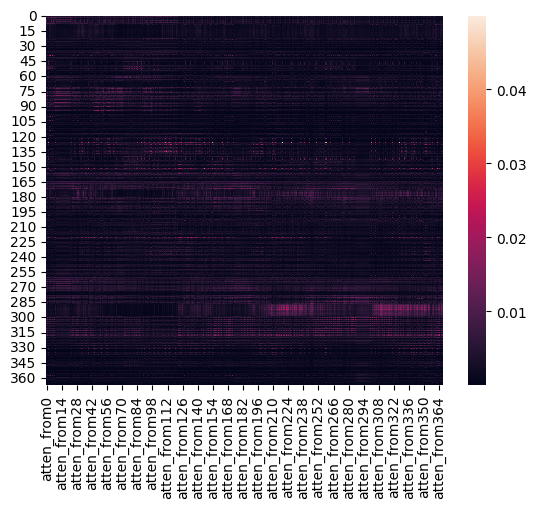

2023-01-21 03:09:46 - INFO - 2822292237.py - 14 - The pred ranking about DevilsFoot:Sterndale is 0


,predicate,whom,subject,why,what,where
0,word.predicate:exist,DevilsFoot:Mortimer,DevilsFoot:Sterndale,DevilsFoot:Sterndale,<bos_e>,DevilsFoot:Sterndale
1,word.predicate:go,DevilsFoot:Sterndale,DevilsFoot:Mortimer,DevilsFoot:Mortimer,DevilsFoot:Sterndale,DevilsFoot:Mortimer
2,<bos_e>,<bos_e>,AllTitle:Holmes,DevilsFoot:Roundhay,DevilsFoot:Mortimer,<bos_e>
3,word.predicate:meet,DevilsFoot:Brenda,DevilsFoot:Brenda,<bos_e>,DevilsFoot:George,DevilsFoot:George
4,word.predicate:think,DevilsFoot:Roundhay,DevilsFoot:Roundhay,DevilsFoot:George,DevilsFoot:Brenda,DevilsFoot:Roundhay
5,word.predicate:enter,DevilsFoot:George,DevilsFoot:George,DevilsFoot:Brenda,DevilsFoot:Roundhay,AllTitle:Holmes
6,word.predicate:return,AllTitle:Holmes,DevilsFoot:Owen,DevilsFoot:Owen,AllTitle:Holmes,DevilsFoot:Brenda
7,word.predicate:have,DevilsFoot:Owen,<bos_e>,DevilsFoot:telegram,DevilsFoot:Owen,DevilsFoot:cottage_of_Pordeux_Bay
8,word.predicate:see,DevilsFoot:Porter,AllTitle:Watson,DevilsFoot:Porter,DevilsFoot:window,DevilsFoot:window
9,word.predicate:kill,AllTitle:Watson,DevilsFoot:Doctor_Richard,DevilsFoot:window,AllTitle:Watson,DevilsFoot:living_room


358

['DevilsFoot:489', 'kgc:hasPredicate', 'word.predicate:find']

,head,relation,tail,atten_from358
152,DevilsFoot:441,kgc:infoSource,DevilsFoot:Sterndale,0.025073
126,DevilsFoot:436,kgc:infoSource,DevilsFoot:Sterndale,0.020752
331,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.013438
220,DevilsFoot:457,kgc:infoSource,DevilsFoot:Sterndale,0.012454
335,DevilsFoot:482,kgc:infoSource,DevilsFoot:Sterndale,0.011225
122,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.009457
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.009016
157,DevilsFoot:442,kgc:infoSource,DevilsFoot:Sterndale,0.008403
288,DevilsFoot:473,kgc:what,DevilsFoot:475,0.007799
291,DevilsFoot:473,kgc:what,DevilsFoot:478,0.007534


----------


359

['DevilsFoot:489', 'kgc:what', 'DevilsFoot:gravel']

,head,relation,tail,atten_from359
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.014347
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.013657
288,DevilsFoot:473,kgc:what,DevilsFoot:475,0.012266
293,DevilsFoot:473,kgc:what,DevilsFoot:480,0.010961
296,DevilsFoot:473,kgc:what,DevilsFoot:484,0.010652
291,DevilsFoot:473,kgc:what,DevilsFoot:478,0.010466
294,DevilsFoot:473,kgc:what,DevilsFoot:481,0.009887
295,DevilsFoot:473,kgc:what,DevilsFoot:483,0.009428
297,DevilsFoot:473,kgc:what,DevilsFoot:485,0.009307
289,DevilsFoot:473,kgc:what,DevilsFoot:476,0.009289


----------


360

['<bos_e>', '<bos_r>', '<bos_e>']

,head,relation,tail,atten_from360
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.008715
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.008044
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.007371
273,DevilsFoot:471,kgc:subject,DevilsFoot:Mortimer,0.007135
87,<bos_e>,<bos_r>,<bos_e>,0.006861
80,<bos_e>,<bos_r>,<bos_e>,0.006744
71,<bos_e>,<bos_r>,<bos_e>,0.006659
308,DevilsFoot:476,kgc:subject,DevilsFoot:Mortimer,0.006574
76,<bos_e>,<bos_r>,<bos_e>,0.006574
182,<bos_e>,<bos_r>,<bos_e>,0.006561


----------


361

['<mask_e>', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from361
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.013074
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.012488
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.012138
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.011302
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.010832
8,DevilsFoot:412,kgc:hasPredicate,word.predicate:say,0.010224
281,DevilsFoot:472,kgc:hasPredicate,word.predicate:say,0.010100
179,DevilsFoot:446,kgc:what,DevilsFoot:444,0.009891
304,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.009610
315,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.009445


----------


362

['<mask_e>', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from362
152,DevilsFoot:441,kgc:infoSource,DevilsFoot:Sterndale,0.030405
126,DevilsFoot:436,kgc:infoSource,DevilsFoot:Sterndale,0.028155
331,DevilsFoot:482,kgc:subject,DevilsFoot:Sterndale,0.020943
335,DevilsFoot:482,kgc:infoSource,DevilsFoot:Sterndale,0.015084
220,DevilsFoot:457,kgc:infoSource,DevilsFoot:Sterndale,0.014946
122,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.011889
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.011289
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.010224
157,DevilsFoot:442,kgc:infoSource,DevilsFoot:Sterndale,0.009650
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.009394


----------


363

['<mask_e>', 'kgc:whom', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from363
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.017063
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.015604
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.014267
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.014240
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.013748
304,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.012193
306,DevilsFoot:475,kgc:infoSource,DevilsFoot:Sterndale,0.011665
308,DevilsFoot:476,kgc:subject,DevilsFoot:Mortimer,0.011372
315,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.011364
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.011137


----------


364

['<mask_e>', 'kgc:subject', '<mask_e>']

,head,relation,tail,atten_from364
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.025853
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.021523
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.019501
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.017363
315,DevilsFoot:477,kgc:infoSource,DevilsFoot:Sterndale,0.014508
152,DevilsFoot:441,kgc:infoSource,DevilsFoot:Sterndale,0.014169
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.014119
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.011932
306,DevilsFoot:475,kgc:infoSource,DevilsFoot:Sterndale,0.011906
304,DevilsFoot:475,kgc:subject,DevilsFoot:Sterndale,0.011902


----------


365

['<mask_e>', 'kgc:why', '<mask_e>']

,head,relation,tail,atten_from365
87,<bos_e>,<bos_r>,<bos_e>,0.007320
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.007243
181,DevilsFoot:446,kgc:infoSource,DevilsFoot:Sterndale,0.007185
89,<bos_e>,<bos_r>,<bos_e>,0.006935
296,DevilsFoot:473,kgc:what,DevilsFoot:484,0.006827
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.006761
172,DevilsFoot:446,kgc:subject,DevilsFoot:Sterndale,0.006741
286,DevilsFoot:473,kgc:subject,DevilsFoot:Sterndale,0.006723
183,DevilsFoot:447,kgc:subject,DevilsFoot:Sterndale,0.006693
273,DevilsFoot:471,kgc:subject,DevilsFoot:Mortimer,0.006492


----------


366

['<mask_e>', 'kgc:what', '<mask_e>']

,head,relation,tail,atten_from366
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.016870
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.016710
288,DevilsFoot:473,kgc:what,DevilsFoot:475,0.014026
294,DevilsFoot:473,kgc:what,DevilsFoot:481,0.012674
291,DevilsFoot:473,kgc:what,DevilsFoot:478,0.012566
296,DevilsFoot:473,kgc:what,DevilsFoot:484,0.012464
286,DevilsFoot:473,kgc:subject,DevilsFoot:Sterndale,0.011705
293,DevilsFoot:473,kgc:what,DevilsFoot:480,0.011475
297,DevilsFoot:473,kgc:what,DevilsFoot:485,0.011329
289,DevilsFoot:473,kgc:what,DevilsFoot:476,0.011157


----------


367

['<mask_e>', 'kgc:where', '<mask_e>']

,head,relation,tail,atten_from367
313,DevilsFoot:477,kgc:subject,DevilsFoot:Mortimer,0.014231
317,DevilsFoot:478,kgc:subject,DevilsFoot:Mortimer,0.013427
318,DevilsFoot:478,kgc:infoSource,DevilsFoot:Sterndale,0.011704
290,DevilsFoot:473,kgc:what,DevilsFoot:477,0.011174
292,DevilsFoot:473,kgc:what,DevilsFoot:479,0.010526
243,DevilsFoot:463,kgc:subject,DevilsFoot:Mortimer,0.010226
186,DevilsFoot:448,kgc:subject,DevilsFoot:Mortimer,0.009874
128,DevilsFoot:437,kgc:subject,DevilsFoot:Mortimer,0.009751
320,DevilsFoot:479,kgc:subject,DevilsFoot:Sterndale,0.009334
326,DevilsFoot:481,kgc:subject,DevilsFoot:Mortimer,0.009290


----------


In [32]:
def do_devil2_pred():
    title = 'DevilsFoot'
    victim_name = 'Mortimer'
    killer_name = 'Sterndale'
    last_index = 489
    story_len = 80
    df_ranking_DevilsFoot2, df_attension_DevilsFoot2 = check_killer(title, victim_name, killer_name, last_index, story_len)
do_devil2_pred()

### 背中の曲がった男: 
Why did Barclay die?
被害者: Barclay
犯人: 
犯行動機: 

In [ ]:
victim = 'CrookedMan:Barclay'
df_ranking_CrookedMan, df_attension_CrookedMan = make_ranking(
    f'CrookedMan:{373-80+1}', 'CrookedMan:373', DIE, MASK_E, victim, MASK_E, MASK_E, MASK_E)

display(df_ranking_CrookedMan.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_CrookedMan)
for i in range(len_-20, len_):
    display(i, df_attension_CrookedMan.iloc[i,:3].tolist())
    display(df_attension_CrookedMan.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 僧坊荘園
Who killed Lord Blackenstall? (criminal & explanation)
被害者: Sir_Eustace_Brackenstall
犯人: 
犯行動機: 

In [ ]:
title = 'AbbeyGrange'
victim_name = 'Sir_Eustace_Brackenstall'
killer_name = 'Jack_Croker'
last_index = 414
story_len = 80

df_ranking_AbbeyGrange, df_attension_AbbeyGrange = main_func01(title, victim_name, killer_name, last_index, story_len)

### 入院患者
Who killed Blessington? (criminal & explanation)
被害者: Blessington
犯人: 3人
犯行動機: 

In [ ]:
title = 'ResidentPatient'
victim_name = 'Blessington'
killer_name = ''
last_index = 324
story_len = 80

df_ranking_Blessington, df_attension_Blessington = main_func01(title, victim_name, killer_name, last_index, story_len)

### 白銀
Who took out the White Silver Blaze? (criminal & explanation) 
被害者: Silver_Blaze
犯人: 
犯行動機: 

In [ ]:
victim = 'SilverBlaze:Silver_Blaze'
df_ranking_SilverBlaze, df_attension_SilverBlaze = make_ranking(
    'SilverBlaze:330', 'SilverBlaze:396', BRING, MASK_E, MASK_E, MASK_E, victim, MASK_E)

display(df_ranking_SilverBlaze.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_SilverBlaze)
for i in range(len_-20, len_):
    display(i, df_attension_SilverBlaze.iloc[i,:3].tolist())
    display(df_attension_SilverBlaze.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")

### 花嫁失踪事件（同一事件）
hozmaの失踪の名瀬を探る
被害者: ACaseOfIdentity:Hozma
犯人: 
犯行動機: 

In [ ]:
victim = 'ACaseOfIdentity:Hosmer'
df_ranking_ACaseOfIdentity, df_attension_ACaseOfIdentity = make_ranking(
    'ACaseOfIdentity:510', 'ACaseOfIdentity:578', HIDE, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_ACaseOfIdentity.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_ACaseOfIdentity)
for i in range(len_-20, len_):
    display(i, df_attension_ACaseOfIdentity.iloc[i,:3].tolist())
    display(df_attension_ACaseOfIdentity.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")
